# Tectonic subsidence from backstripping

In this example we backstrip and visualize the decompaction of stratigraphic layers at a shallow continental drill site location, and overlay tectonic subsidence to compare its subsidence contribution with that of sedimentation.

The drill site has recorded paleo-water depths which, along with sediment decompaction, reveal tectonic subsidence.


## Reference

The following paper covers the theory and algorithms of pyBacktrack:

* Müller, R. D., Cannon, J., Williams, S. and Dutkiewicz, A., 2018,
  PyBacktrack 1.0: A Tool for Reconstructing Paleobathymetry on Oceanic and Continental Crust,
  **Geochemistry, Geophysics, Geosystems,** 19, 1898-1909, doi: [10.1029/2017GC007313](https://doi.org/10.1029/2017GC007313)

## Locations of NW Shelf wells

The well names and associated locations are read from a file and then plotted with a topography/bathymetry background image.

In [1]:
# Function to read well names and locations.
# Returns a dictionary mapping names to (latitude, longitude) location tuples.
def read_well_locations_file(well_locations_filename):
    well_locations = {}
    
    with open(well_locations_filename, 'r') as well_locations_file:
        # Skip the header line.
        well_locations_file.readline()
        
        while True:
            header_line = well_locations_file.readline()
            if not header_line:
                # EOF.
                break
            
            # There can be spaces in the well name, but there's also text after the well name (on same line).
            # Currently it looks like:
            #  * For those lines containing only spaces, the well name does not go past a certain column.
            #  * For those lines containing some tabs, the well name is the part before the first tab.
            well_name = header_line.split('\t', 1)[0][1:17].strip().lower()
            # Remove numbers at end of well names.
            if well_name[-1] == '1' or well_name[-1] == '2' or well_name[-1] == '3':
                well_name = well_name[0:-1]
                if well_name[-1] == ' ' or well_name[-1] == '-':
                    well_name = well_name[0:-1]
            
            data_line = well_locations_file.readline()
            data = data_line.split()
            
            well_location = float(data[0]), float(data[1])
            well_locations[well_name] = well_location
    
    return well_locations

# Get a dictionary mapping names to locations for all available wells.
well_locations = read_well_locations_file('WELL_LOCATIONS.lst')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_well_locations(
        well_locations,
        min_longitude,
        max_longitude,
        min_latitude,
        max_latitude):
    plt.figure(figsize=(20,20))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title('NW Shelf wells', fontsize=16)

    # Region of map to show.
    ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude])

    # Topography/bathymetry background.
    topography_image = plt.imread('Topography.png')
    topography_image_extent=[90,135,-45,0]
    ax.imshow(topography_image, origin='upper', extent=topography_image_extent, transform=ccrs.PlateCarree())

    # Coastlines.
    #ax.coastlines(resolution='50m')
    #ax.coastlines()

    # Plot each well location, and label with well name.
    well_names = well_locations.keys()
    for well_name in well_names:
        well_latitude, well_longitude = well_locations[well_name]
        # Only plot well if it's inside the region we're showing.
        if (well_latitude >= min_latitude and well_latitude <= max_latitude and
            well_longitude >= min_longitude and well_longitude <= max_longitude):
            ax.plot(well_longitude, well_latitude, 'ko', markersize=3, transform=ccrs.Geodetic())
            ax.text(well_longitude, well_latitude, well_name, transform=ccrs.Geodetic())

    plt.show()

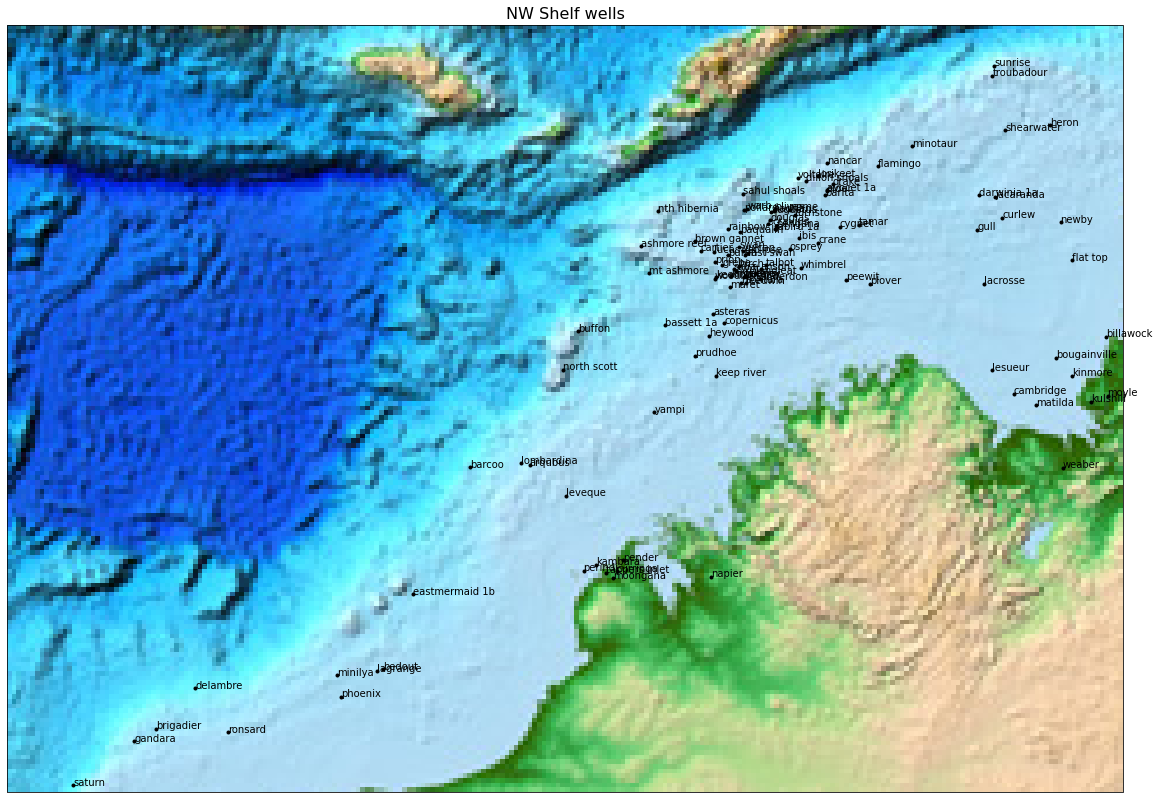

In [3]:
plot_well_locations(well_locations, min_longitude=114, max_longitude=130, min_latitude=-20, max_latitude=-9)

## Some zoomed-in plots

Some zoomed-in plots to see the well names more clearly.

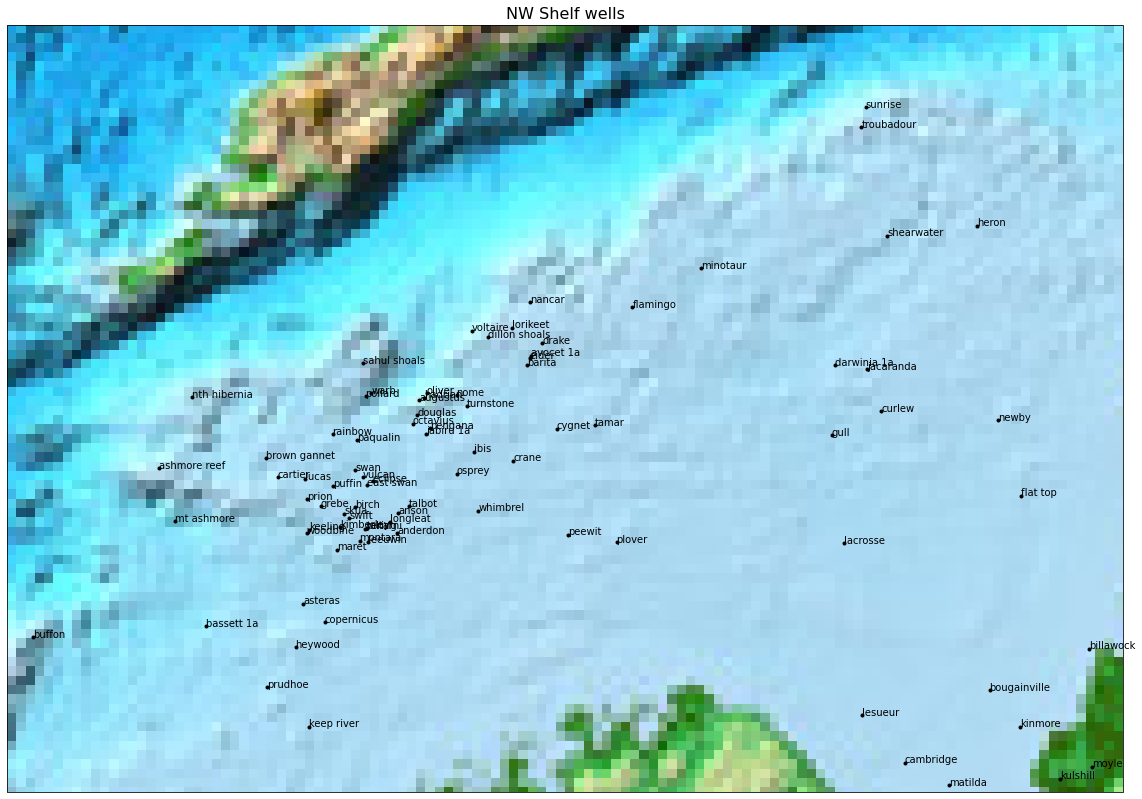

In [4]:
plot_well_locations(well_locations, min_longitude=122, max_longitude=130, min_latitude=-14.5, max_latitude=-9)

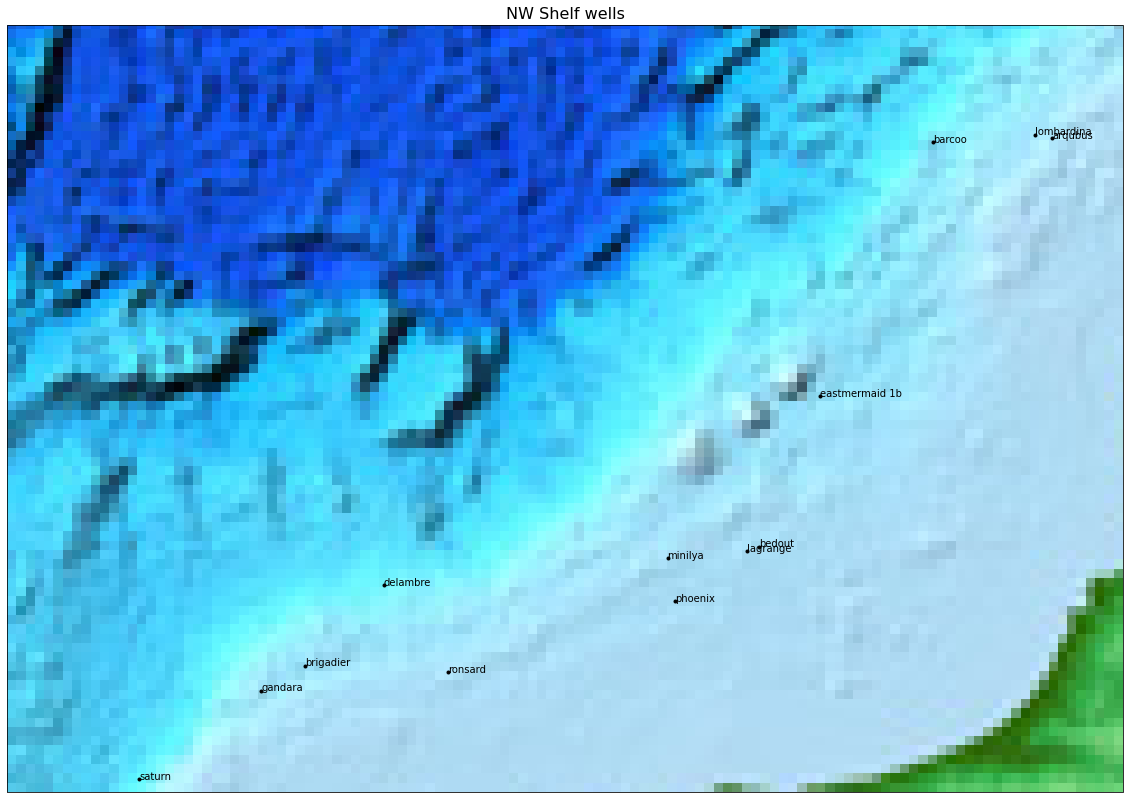

In [5]:
plot_well_locations(well_locations, min_longitude=114, max_longitude=122, min_latitude=-20, max_latitude=-14.5)

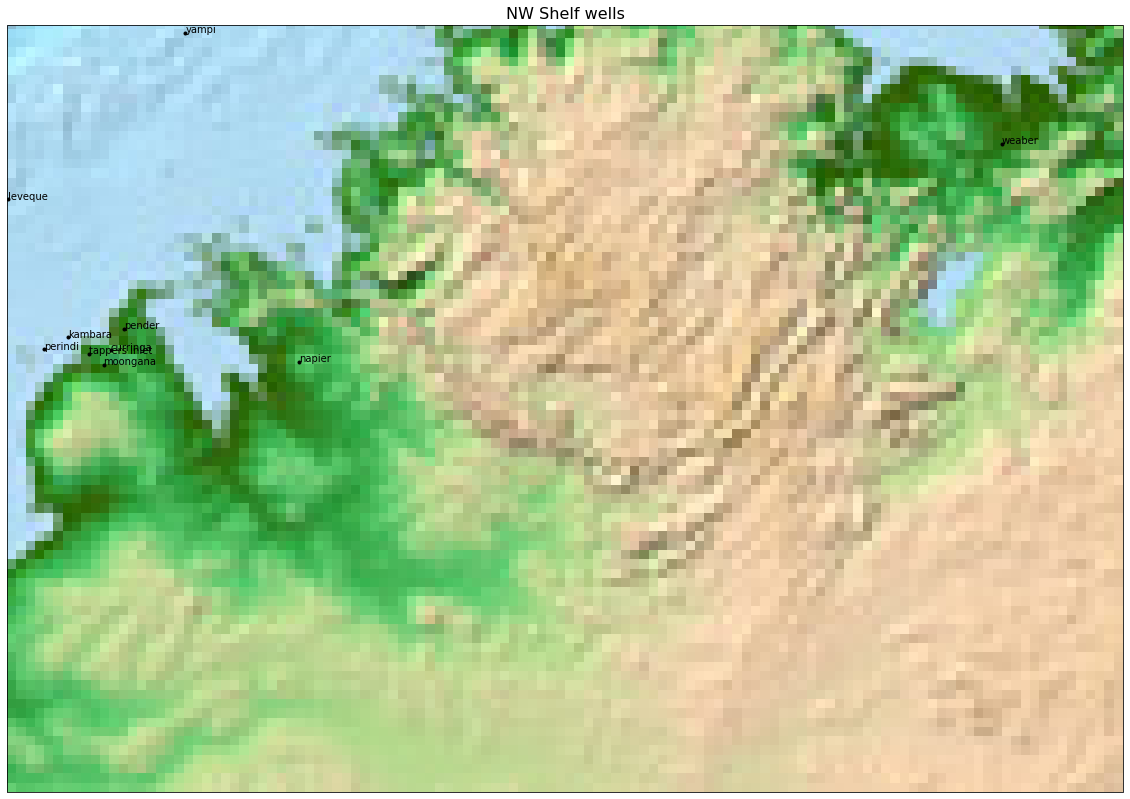

In [6]:
plot_well_locations(well_locations, min_longitude=122, max_longitude=130, min_latitude=-20, max_latitude=-14.5)

## Analyze a particular well

Here we select a particular well for backstripping.

In [7]:
import pybacktrack

#
# Each drill site file specifies then depths, ages and lithologies of its stratigraphic layers.
#
# A shallow continental drill site file used with backstripping.
backstrip_well_filename = 'wells/sunrise.txt'
#backstrip_well_filename = 'wells/barcoo1.dat'

In [8]:
import warnings

# Ignore user warnings related to well thickness being larger than total sediment thickness.
#
# This happens because the default total sediment thickness grid is not as accurate near continental margins
# like the 'sunrise' drill site (compared to deeper ocean basins).
warnings.filterwarnings("ignore", "Well thickness .* is larger than the total sediment thickness")

# Ignore user warnings related to dynamic topography sampling.
#
# This happens when the age of interpolated dynamic topography grids are older than the crust at the drill site location.
warnings.filterwarnings("ignore", ".* does not cover, or cannot interpolate, well location .*")

## Function to plot tectonic subsidence showing paleo-water depth uncertainty

Here we plot tectonic subsidence versus age. At the age of each stratigraphic layer an error bar is displaying showing the uncertainty in tectonic subsidence due to the uncertainty in recorded paleo-water depths in the drill site (each layer has a minimum and maximum water depth).

In [9]:
import numpy as np

def get_residuals(rift_subsidence_output, ages, tectonic_subsidences, dynamic_topography_depths, offset):
    residuals=[]
    for beta_index, (rift_subsidence_ages, rift_subsidence_subsidences) in enumerate(rift_subsidence_output):
        interpolated_rift_data = np.interp(ages,np.flip(rift_subsidence_ages),np.flip(rift_subsidence_subsidences))
        residual = np.array(tectonic_subsidences)-np.array(dynamic_topography_depths)-np.array(interpolated_rift_data)-offset
        residuals.append(residual.tolist())
    return residuals

def get_residuals_from_wells(rift_subsidence_output, decompacted_wells, dynamic_topography_model, offset=0):
    ages = [decompacted_well.get_age()
            for decompacted_well in decompacted_wells]
    tectonic_subsidences = [decompacted_well.get_tectonic_subsidence()
            for decompacted_well in decompacted_wells]  
    dynamic_topography_depths = [-dynamic_topography_model.sample(decompacted_well.get_age())
                for decompacted_well in decompacted_wells]
    return get_residuals(rift_subsidence_output, ages, tectonic_subsidences, dynamic_topography_depths, offset)
    
def plot_tectonic_subsidence(
        ax,
        decompacted_wells,
        dynamic_topography_model=None,
        rift_subsidence_output=None,
        offset=0,
        plot_sea_level=False,
        plot_subsidence_minus_dynamic_topography=False,
        plot_rift_subsidence_output=True,
        plot_dynamic_topography=True,
        plot_tectonic_minus_dynamic_topography_minus_rift=False,
        plot_tectonic_subsidence_data=True):

    # 'decompacted_wells' is a list of pybacktrack.DecompactedWell.
    # Extract the age and tectonic subsidence from each decompacted well in the list.
    ages = [decompacted_well.get_age()
            for decompacted_well in decompacted_wells]
    tectonic_subsidences = [decompacted_well.get_tectonic_subsidence()
            for decompacted_well in decompacted_wells]
    min_max_tectonic_subsidences = [decompacted_well.get_min_max_tectonic_subsidence()
            for decompacted_well in decompacted_wells]
    tectonic_subsidence_uncertainties = [0.5 * (max_tectonic_subsidence - min_tectonic_subsidence)
            for min_tectonic_subsidence, max_tectonic_subsidence in min_max_tectonic_subsidences]
    
    if plot_sea_level:
        # Keep track of the sea level (relative to present day) at each age.
        #
        # NOTE: Positive values represent sea-level rise which is the opposite of depth
        # (which is positive going down).
        # So we need to negate sea level to turn a rise into a depth.
        sea_level_depths = [-decompacted_well.get_sea_level()
                for decompacted_well in decompacted_wells]
    
    if dynamic_topography_model:
        # Keep track of the dynamic topography at each age.
        #
        # NOTE: Positive values represent elevation which is the opposite of subsidence
        # (which is positive going down).
        # So we need to negate dynamic topography to turn an elevation into a depth.
        dynamic_topography_depths = [-dynamic_topography_model.sample(decompacted_well.get_age())
                for decompacted_well in decompacted_wells]


    if plot_tectonic_subsidence_data:
        # Plot tectonic subsidence.
        ax.errorbar(
            ages,
            tectonic_subsidences,
            yerr=tectonic_subsidence_uncertainties,
            fmt='-o',
            color='black',
            label='tectonic subsidence',
            linestyle='-',
            linewidth=2.0)

    if plot_sea_level:
        # Plot sea level.
        ax.plot(
            ages,
            sea_level_depths,
            color='blue',
            label='sea level',
            linestyle='-',
            linewidth=2.0)

    if dynamic_topography_model and plot_dynamic_topography:
        # Plot dynamic topography.
        ax.plot(
            ages,
            dynamic_topography_depths,
            color='red',
            label='dynamic topography',
            linestyle='-',
            linewidth=2.0)
    
    if plot_subsidence_minus_dynamic_topography:
        # Plot tectonic subsidence minus dynamic topography.
        ax.errorbar(
            ages,
            [(tectonic_subsidences[age_index] - dynamic_topography_depths[age_index])
                 for age_index in range(len(ages))],
            yerr=tectonic_subsidence_uncertainties,
            fmt='-o',
            color='magenta',
            label='tectonic subsidence rel. dynamic topography',
            linestyle='-',
            linewidth=2.0)
    
    if rift_subsidence_output and plot_rift_subsidence_output:
        for beta_index, (rift_subsidence_ages, rift_subsidence_subsidences) in enumerate(rift_subsidence_output):
            # Plot tectonic subsidence output by RiftSubsidence program (for a specific BETA).
            ax.plot(
                rift_subsidence_ages,
                [ x + offset for x in rift_subsidence_subsidences],
                color='green',
                label='rift subsidence {0}'.format(beta_index+1),
                linestyle='-',
                linewidth=2.0)
            
    if plot_tectonic_minus_dynamic_topography_minus_rift:
        colours=['red', 'blue', 'green']
        residuals=get_residuals(rift_subsidence_output,ages,tectonic_subsidences,dynamic_topography_depths,offset)
        assert len(colours) == len(residuals) #colours and residuals must have the same length
        # Plot tectonic subsidence minus dynamic topography minus rift subsidence.
        for colour, residual, beta_index in zip(colours,residuals,range(len(colours))):
            ax.errorbar(
                ages,
                residual,
                yerr=tectonic_subsidence_uncertainties,
                fmt='-o',
                color=colour,
                label=f'subsidence residual {beta_index+1}',
                linestyle='-',
                linewidth=2.0)
        ax.set_title(f'Subsidence Residual(offset:{offset})')

    ax.invert_xaxis()
    ax.invert_yaxis()

    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.set_xlabel('Age (Ma)', fontsize=12)
    ax.grid(linestyle='--',alpha=0.5)
    ax.legend(fontsize=10)

    return 

## Calculate tectonic subsidence and show paleo-water depth uncertainty

Here we use the [pybacktrack.backstrip_well](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.backstrip_well) function to find the tectonic subsidence for each age in the well site. It returns a list of [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) and from each one we extract an age and a tectonic subsidence.

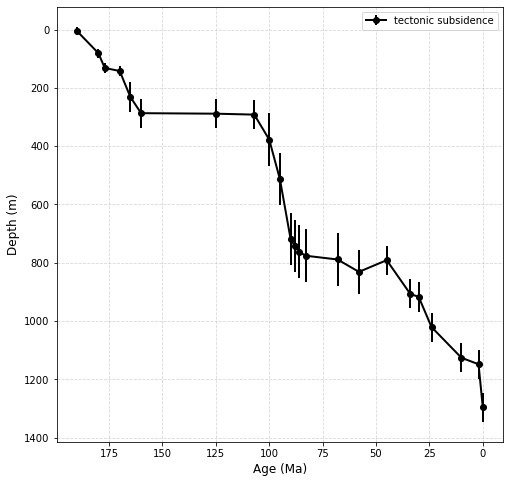

In [10]:
# Backstrip to find the tectonic subsidence for each age in the well site.
well, decompacted_wells = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)

fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(fig.gca(), decompacted_wells)

## Calculate tectonic subsidence using a global sea level curve

Here we calculate tectonic subsidence again, but this time also using a sea level model.

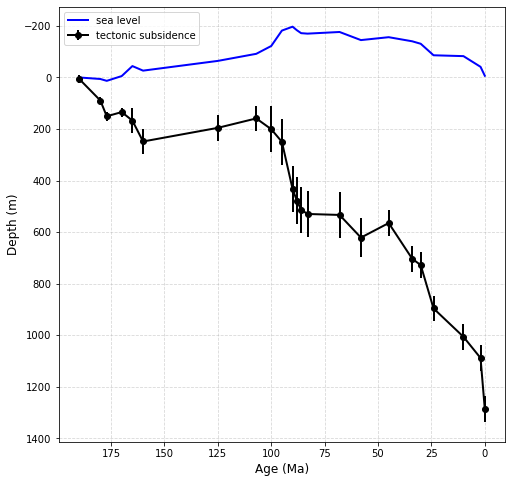

In [11]:
# Backstrip to find the tectonic subsidence for each age in the well site.
#
# But also include the built-in 'Haq87_SealevelCurve_Longterm' sea level model. 
well, decompacted_wells = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    sea_level_model='Haq87_SealevelCurve_Longterm')

fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(fig.gca(), decompacted_wells, plot_sea_level=True)

## Show dynamic topography model 'M6'

Here we also plot the dynamic topography model 'M6' built into pyBacktrack. For all built-in dynamic topography models see http://portal.gplates.org/portal/dt/.

**Note:** Dynamic topography is not affecting the tectonic subsidence here, we're just plotting dynamic topography alongside tectonic subsidence.

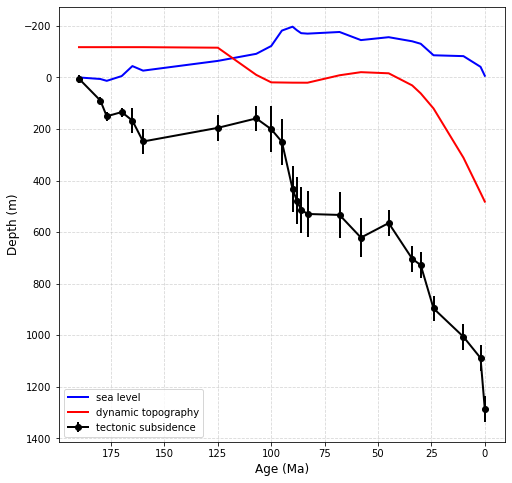

In [12]:
dynamic_topography_model_M6 = pybacktrack.DynamicTopography.create_from_bundled_model(
    'M6', well.longitude, well.latitude)

fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(
    fig.gca(),
    decompacted_wells,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M6)

## Show dynamic topography model 'M7'

Here we plot the dynamic topography model 'M7'.

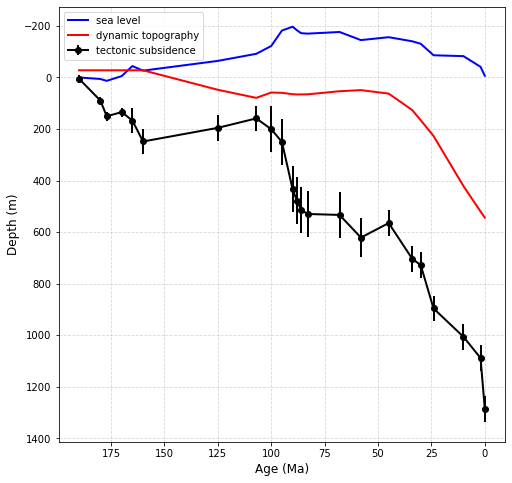

In [13]:
dynamic_topography_model_M7 = pybacktrack.DynamicTopography.create_from_bundled_model(
    'M7', well.longitude, well.latitude)

fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(
    fig.gca(),
    decompacted_wells,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M7)

## Subtract dynamic topography from tectonic subsidence

Here we also plot the tectonic subsidence with dynamic topography subtracted. This shows subsidence relative to dynamic topography.

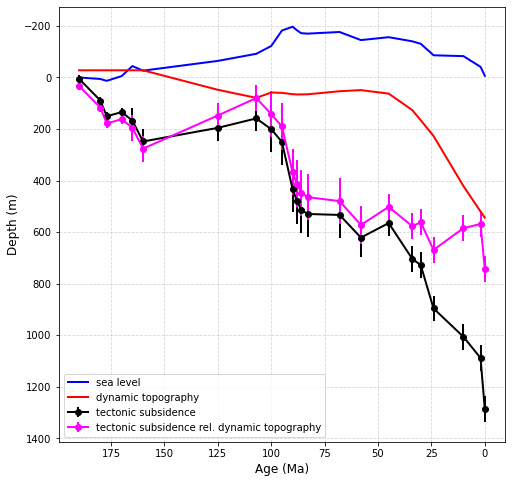

In [14]:
fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(
    fig.gca(),
    decompacted_wells,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M7,
    plot_subsidence_minus_dynamic_topography=True)


## Function to gather the depths of decompacted stratigraphic layers

This function accumulates the decompacted thicknesses of stratigraphic layers at each age.
This is so we know the depth of each decompacted sediment layer below sea level. It also gathers other quantities such as sea level, water depth, tectonic subsidence and dynamic topography.

In [15]:
def get_decompacted_sediment_depths(
        well,
        decompacted_well,
        dynamic_topography_model):
    """
    Return the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # 'decompacted_wells' is a list of pybacktrack.DecompactedWell.
    # Extract the age, water depth, tectonic subsidence and
    # decompacted depths of each stratigraphic layer in the well.
    ages = []
    sea_level_depths = []
    surface_sediment_depths = []
    tectonic_subsidences = []
    dynamic_topography_depths = []

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(well.stratigraphic_units)
    # Each stratigraphic layer will have its own depth vs age curve.
    # Start with an empty list for each layer.
    all_stratigraphic_unit_depths = [[] for i in range(num_stratigraphic_units)]

    # Each successive decompacted well involves stripping off a stratigraphic layer.
    for decompacted_well in decompacted_wells:
        # Keep track of the ages of the top of each stratigraphic layer.
        age = decompacted_well.get_age()
        ages.append(age)

        # Keep track of the sea level (relative to present day) at each age.
        #
        # NOTE: Positive values represent sea-level rise which is the opposite of depth
        # (which is positive going down).
        # So we need to negate sea level to turn a rise into a depth.
        sea_level = decompacted_well.get_sea_level()
        sea_level_depth = -sea_level
        sea_level_depths.append(sea_level_depth)

        # Keep track of the surface sediment depth at each age.
        water_depth = decompacted_well.get_water_depth()
        surface_sediment_depth = sea_level_depth + water_depth
        surface_sediment_depths.append(surface_sediment_depth)

        # Keep track of the tectonic subsidence at each age.
        tectonic_subsidence = decompacted_well.get_tectonic_subsidence()
        tectonic_subsidences.append(tectonic_subsidence)

        # Keep track of the dynamic topography at each age.
        #
        # NOTE: Positive values represent elevation which is the opposite of subsidence
        # (which is positive going down).
        # So we need to negate dynamic topography to turn an elevation into a depth.
        dynamic_topography = dynamic_topography_model.sample(decompacted_well.get_age())
        dynamic_topography_depth = -dynamic_topography
        dynamic_topography_depths.append(dynamic_topography_depth)

        # The number of decompacted stratigraphic layers decreases by one each loop iteration.
        num_decompacted_stratigraphic_units = len(decompacted_well.decompacted_stratigraphic_units)

        # The depth of the current surface layer starts at the surface sediment depth.
        total_decompacted_depth = surface_sediment_depth

        # Iterate over the stratigraphic layers that have already been removed.
        # We'll just give them the current surface sediment depth so
        # we can easily fill colours between curves below.
        stratigraphic_unit_index = 0
        while stratigraphic_unit_index < num_stratigraphic_units - num_decompacted_stratigraphic_units:
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(surface_sediment_depth)
            stratigraphic_unit_index += 1

        # Iterate over the stratigraphic layers still existing at the current time.
        # Each layer has a decompacted thickness which adds to the decompacted depth.
        for decompacted_stratigraphic_unit in decompacted_well.decompacted_stratigraphic_units:
            total_decompacted_depth += decompacted_stratigraphic_unit.decompacted_thickness
            all_stratigraphic_unit_depths[stratigraphic_unit_index].append(total_decompacted_depth)
            stratigraphic_unit_index += 1
        
    return (ages, sea_level_depths, surface_sediment_depths,
            tectonic_subsidences, dynamic_topography_depths, all_stratigraphic_unit_depths)

## Function to plot decompacted stratigraphic layers and tectonic subsidence

This function plots a "depth vs age" curve for each stratigraphic layer in the drill site. It also plots other quantities such as sea level, water depth, tectonic subsidence and dynamic topography.

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

# Choose a colour for each stratigraphic unit.
stratigraphic_unit_colours = [
    'mistyrose', 'bisque', 'lemonchiffon', 'lightgreen', 'aquamarine', 'powderblue', 'lavender', 'thistle']

def plot_decompacted_sediment_depths(
        ax,
        ages,
        sea_level_depths,
        surface_sediment_depths,
        tectonic_subsidences,
        dynamic_topography_depths,
        all_stratigraphic_unit_depths):
    """
    Plot the decompacted sediment depths over time, and
    sea-level, surface sediment depth and tectonic subsidence.
    """

    # The total number of stratigraphic layers at present day.
    num_stratigraphic_units = len(all_stratigraphic_unit_depths)
    
    ax.set_title('Geohistory analysis', fontsize=16)

    for stratigraphic_unit_index in range(num_stratigraphic_units):
        # Plot a grey line at the top of the current stratigraphic unit.
        ax.plot(
            ages,
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            color='grey',
            linewidth=1.0)
        # Fill the current stratigraphic layer with a colour.
        ax.fill_between(
            ages,
            (all_stratigraphic_unit_depths[stratigraphic_unit_index-1]
                 if stratigraphic_unit_index > 0
                 else surface_sediment_depths),
            all_stratigraphic_unit_depths[stratigraphic_unit_index],
            facecolor=stratigraphic_unit_colours[stratigraphic_unit_index % len(stratigraphic_unit_colours)])

    # Fill blue from sea-level depth down to surface sediment depth to indicate water.
    ax.fill_between(
        ages,
        sea_level_depths,
        surface_sediment_depths,
        facecolor='royalblue')

    # Plot surface sediment depth.
    ax.plot(
        ages,
        surface_sediment_depths,
        color='black',
        label='surface sediment',
        linestyle='-',
        linewidth=2.0)

    # Plot tectonic subsidence.
    ax.plot(
        ages,
        tectonic_subsidences,
        color='black',
        label='tectonic subsidence',
        linestyle='--',
        linewidth=2.0)

    # Plot dynamic topography.
    ax.plot(
        ages,
        dynamic_topography_depths,
        color='red',
        label='dynamic topography',
        linestyle='-.',
        linewidth=2.0)

    ax.invert_xaxis()
    ax.invert_yaxis()

    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.set_xlabel('Age (Ma)', fontsize=12)
    ax.grid(linestyle='--',alpha=0.5)

    ax.legend(fontsize=10)

    return

## Calculate decompacted stratigraphic layers

Here we plot the decompacted thicknesses of stratigraphic layers at each age.

The sea level (top of blue fill) shows a general uplift relative to the present day sea level.

We also plot tectonic subsidence and dynamic topography model 'M7'.

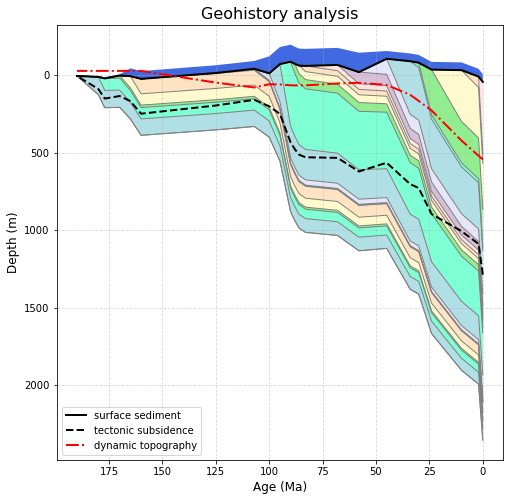

In [17]:
# Retrieve and plot the decompacted sediment depths, etc.
fig = plt.figure(figsize=(8,8))
plot_decompacted_sediment_depths(
    fig.gca(),
    *get_decompacted_sediment_depths(well, decompacted_wells, dynamic_topography_model_M7))

## Run RiftSubsidence to calculate subsidence curves

**NOTE:** If you change drill site filename (in the *backstrip_well_filename* variable at the top), then also change the label parameter in parameters.json. For example, if you change the drill site to 'wells/buffon.txt' then use 'buffon' for the label here (and also change the *rift_subsidence_label* variable in the last cell below).

**NOTE:** We used '1.301' instead of '1.3' for the maximum value of BETA to ensure we get all three BETA values (1.1, 1.2, 1.3).

### RiftSubsidence parameters

The parameters can be modified in [parameters.json](parameters.json).

In [18]:
import RiftSubsidence as rs

#load cfg file
rs.read_cfg_file('parameters.json')

#run RiftSubsidence with parameters in parameters.json
rs.run()

#Done! The output has been saved in {PLABEL}.dat. The PLABEL is a parameter in parameters.json.

 Lithospheric thickness is 117.512502 kilometres

Beta1 = 1.1 .... 

Rift Period 1 ....
Calculating temperature structure....

T = 0.0025       	 Q = -0.003       	 BETA = 1.0065      
T = 0.005        	 Q = -0.0058      	 BETA = 1.0131      
T = 0.0075       	 Q = -0.0085      	 BETA = 1.0197      
T = 0.01         	 Q = -0.011       	 BETA = 1.0263      
T = 0.0125       	 Q = -0.0135      	 BETA = 1.033       
T = 0.015        	 Q = -0.0159      	 BETA = 1.0397      
T = 0.0175       	 Q = -0.0182      	 BETA = 1.0465      
T = 0.02         	 Q = -0.0204      	 BETA = 1.0533      
T = 0.0225       	 Q = -0.0226      	 BETA = 1.0602      
T = 0.025        	 Q = -0.0247      	 BETA = 1.0671      
T = 0.0275       	 Q = -0.0267      	 BETA = 1.0741      
T = 0.03         	 Q = -0.0287      	 BETA = 1.0811      
T = 0.0325       	 Q = -0.0306      	 BETA = 1.0881      
T = 0.035        	 Q = -0.0325      	 BETA = 1.0952      
T = 0.0367       	 Q = -0.0337      	 BETA = 1.1         

Be

## Function to read the output of *RiftSubsidence*

The following function reads the output generated by *RiftSubsidence*. The output will contain a subsidence versus age curve for each BETA value in the range (specified in the parameters.json).

In [19]:
def read_rift_subsidence_output(rift_subsidence_output_label):
    
    # Read all lines in the RiftSubsidence output file.
    rift_subsidence_output_filename = '{0}.dat'.format(rift_subsidence_output_label)
    with open(rift_subsidence_output_filename, 'r') as rift_subsidence_output_file:
        lines = rift_subsidence_output_file.readlines()
    
    beta_groups = []
    
    # First beta group starts with age and subsidence lists.
    beta_groups.append(([], []))
    
    for line in lines:
        line = line.strip()
        # If encounter empty line then we're finished.
        if not line:
            break
        
        # Get age and subsidence.
        age, subsidence, _, _ = [float(item) for item in line.split()]
        if age < 0.0:
            # Start a new beta group with empty age and subsidence lists.
            beta_groups.append(([], []))
            continue
        
        # Convert subsidence from Km to metres.
        subsidence *= 1000
        
        # Add to end of current beta group (last group in beta list).
        beta_groups[-1][0].append(age)
        beta_groups[-1][1].append(subsidence)
    
    return beta_groups

## Read and plot RiftSubsidence output

The next cell actually reads the output file generated by running *RiftSubsidence* in the above cell. So the following cell should be re-run each time you run *RiftSubsidence*. For example, you can change the BETA minimum, maximum and increment until the green subsidence curves best match the black subsidence curve produced by backstripping.

The label passed to the *read_rift_subsidence_output()* function below should match the label specified in the parameters.json.

**NOTE**: You'll need to adjust the label below after each *RiftSubsidence* run to pick up the latest run results.

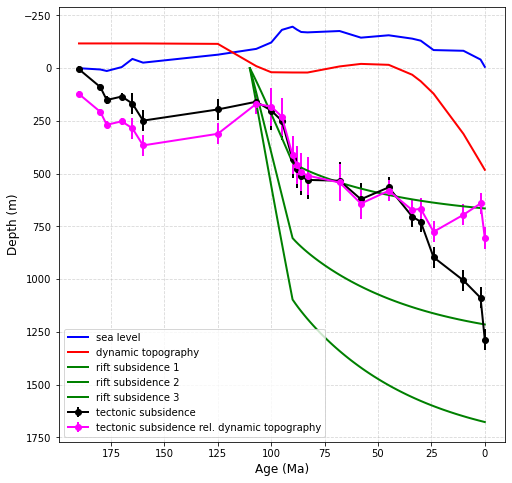

In [20]:
# Specify the label you specified in the parameters.json.
rift_subsidence_label = 'sunrise'

# Read the output from running RiftSubsidence.
rift_subsidence_output_run = read_rift_subsidence_output(rift_subsidence_label)

# Plot the backstripped tectonic subsidence, along with the subsidence output by RiftSubsidence for various BETA values.
fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(
    fig.gca(),
    decompacted_wells,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M6,
    plot_subsidence_minus_dynamic_topography=True,
    rift_subsidence_output=rift_subsidence_output_run,
    offset=0)

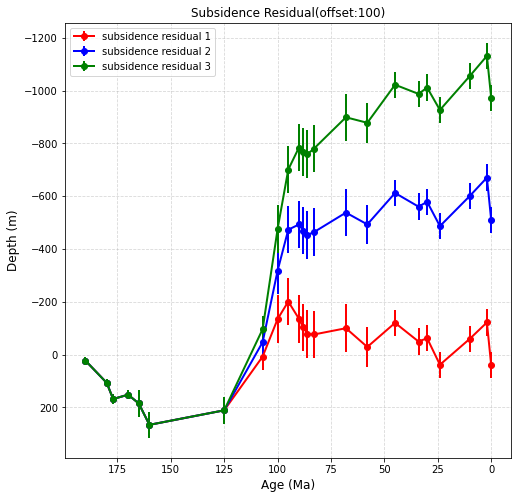

In [21]:
# Specify the label you specified in the parameters.json.
rift_subsidence_label = 'sunrise'

# Read the output from running RiftSubsidence.
rift_subsidence_output_run = read_rift_subsidence_output(rift_subsidence_label)

# Plot the backstripped tectonic subsidence, along with the subsidence output by RiftSubsidence for various BETA values.
fig = plt.figure(figsize=(8,8))
plot_tectonic_subsidence(
    fig.gca(),
    decompacted_wells,
    plot_sea_level=False,
    dynamic_topography_model=dynamic_topography_model_M6,
    plot_subsidence_minus_dynamic_topography=False,
    rift_subsidence_output=rift_subsidence_output_run,
    offset=100,
    plot_dynamic_topography=False,
    plot_tectonic_subsidence_data=False,
    plot_rift_subsidence_output = False,
    plot_tectonic_minus_dynamic_topography_minus_rift = True)

In [22]:
def get_age_window_indices(start_age, end_age, ages):
    '''get the start age and end age indices
    
        Parameters:
        -----------
        start_age: start age
        end_age: end age
        ages: an array of ages
        
        Return:
        -------
        start_index: the index of start age in the array "ages"
        end_index: the index of end age in the array "ages"
        
        Note:
        -----
        The start age and end age define a window. 
        The program finds all ages within the window from the "ages" array.
        The result ages are bounded by the start_index and end_index.
    '''
    start_index=None
    end_index=len(ages)
    for i in range(len(ages)):
        if ages[i]>=start_age and start_index is None:
            start_index=i
        if ages[i]>=end_age:
            end_index=i
            break
    if end_index == start_index:
        start_index = None
    if start_index is None:
        end_index=None
    return start_index, end_index
 

def get_mean_and_std(residuals, ages=[], age_window=None):
    '''calculate the mean and standard deviation of residuals
    
        Parameters:
        -----------
        residuals: the input residual array
        ages: the ages associated with the residuals. 
        age_window: the length of age window
        
        Return:
        -------
        Results as string.
        
        Note:
        The "ages" and "age_window" are not required if calculating the mean and standard deviation of all residual.
        For example, if age_window is 50Ma, the program will calculate residuals for each 50Ma intervals, such as
        "0Ma~50Ma", "50Ma~100Ma", "100Ma~150Ma", etc...
    '''
    ret=''
    if age_window is None or not age_window>0 or len(ages)==0:
        ret+='The residuals: \n'
        ret+=f'{np.round(residuals,2)}\n'
        ret+='The mean of residuals: \n'
        ret+=f'{np.round(np.mean(residuals),2)}\n'
        ret+="The standard deviation of residuals: \n"
        ret+=f'{np.round(np.std(residuals),2)}\n'
        ret+='\n'
    else:
        for i in range(int(ages[-1]//age_window+1)):
            start_index, end_index = get_age_window_indices(i*age_window, (i+1)*age_window, ages)
            if end_index > start_index:
                ret+=f'Window: {i*age_window}Ma to {(i+1)*age_window}Ma\n'
                ret+='The ages: \n'
                ret+=f'{ages[start_index:end_index]}\n'
                ret+=get_mean_and_std(residuals[start_index:end_index])
    return ret
 
def compute_residual_stats(label, decompacted_wells,rift_subsidence_output, dynamic_topography_model, offset=0):
    residual_ages = [decompacted_well.get_age() for decompacted_well in decompacted_wells]
    residuals = get_residuals_from_wells(rift_subsidence_output, decompacted_wells, 
                                         dynamic_topography_model,offset=100)
    output=''

    output+='****************Residual 3*****************\n\n'
    output+=f'Ages: {residual_ages}\n'
    output+=get_mean_and_std(residuals[2]) #for all ages
    output+=get_mean_and_std(residuals[2],residual_ages,50)#for each age window

    output+='****************Residual 2*****************\n\n'
    output+=f'Ages: {residual_ages}\n'
    output+=get_mean_and_std(residuals[1])#for all ages
    output+=get_mean_and_std(residuals[1],residual_ages,50)#for each age window

    output+='****************Residual 1*****************\n\n'
    output+=f'Ages: {residual_ages}\n'
    output+=get_mean_and_std(residuals[0])#for all ages
    output+=get_mean_and_std(residuals[0],residual_ages,50)#for each age window

    min_max_tectonic_subsidences = [decompacted_well.get_min_max_tectonic_subsidence()
            for decompacted_well in decompacted_wells]
    tectonic_subsidence_uncertainties = [0.5 * (max_tectonic_subsidence - min_tectonic_subsidence)
            for min_tectonic_subsidence, max_tectonic_subsidence in min_max_tectonic_subsidences]
    
    output+= f'Tectonic Subsidence Uncertainties: {tectonic_subsidence_uncertainties}\n'
    
    print(output)

    fn = f"{label}_residual_stats.txt"
    with open(fn, "w+") as f:
        f.write(output)
    print(f'The result data has been saved in {fn}.')
    
    
compute_residual_stats('sunrise', decompacted_wells,rift_subsidence_output_run, dynamic_topography_model_M6, offset=100)


****************Residual 3*****************

Ages: [0.0, 2.0, 10.0, 24.0, 30.0, 34.0, 45.0, 58.0, 68.0, 83.0, 86.0, 88.0, 90.0, 95.0, 100.0, 107.0, 125.0, 160.0, 165.0, 170.0, 177.0, 180.0, 190.0]
The residuals: 
[ -972.55 -1131.34 -1055.25  -926.45 -1011.39  -987.28 -1022.07  -877.89
  -898.86  -780.01  -759.48  -767.95  -784.31  -700.95  -475.8    -96.41
   210.98   265.98   184.93   151.78   168.25   106.95    22.5 ]
The mean of residuals: 
-527.68
The standard deviation of residuals: 
499.75

Window: 0Ma to 50Ma
The ages: 
[0.0, 2.0, 10.0, 24.0, 30.0, 34.0, 45.0]
The residuals: 
[ -972.55 -1131.34 -1055.25  -926.45 -1011.39  -987.28 -1022.07]
The mean of residuals: 
-1015.19
The standard deviation of residuals: 
60.51

Window: 50Ma to 100Ma
The ages: 
[58.0, 68.0, 83.0, 86.0, 88.0, 90.0, 95.0]
The residuals: 
[-877.89 -898.86 -780.01 -759.48 -767.95 -784.31 -700.95]
The mean of residuals: 
-795.64
The standard deviation of residuals: 
64.18

Window: 100Ma to 150Ma
The ages: 
[100.0

#### This code cell calculates the mean residuals of a given period of time, for example between 65 Ma and 0

In [23]:
#get the residuals and ages
residual_ages = [decompacted_well.get_age() for decompacted_well in decompacted_wells]
residuals = get_residuals_from_wells(rift_subsidence_output_run, decompacted_wells, 
                                         dynamic_topography_model_M6,offset=100)
print(f'residual ages: {residual_ages}')
print(f'residuals: {residuals[0]}')

#get start and end index from time A to time B
time_A = 0
time_B = 65
start_index, end_index = get_age_window_indices(time_A, time_B, residual_ages)
print(f'start time: {time_A}, end time: {time_B}')
print(f'start index: {start_index}, end index: {end_index}')
print(f'calculate mean value for residuals: {residuals[0][start_index:end_index]}')
print(f'The mean value of residuals: {np.round(np.mean(residuals[0][start_index:end_index]),4)}\n')


residual ages: [0.0, 2.0, 10.0, 24.0, 30.0, 34.0, 45.0, 58.0, 68.0, 83.0, 86.0, 88.0, 90.0, 95.0, 100.0, 107.0, 125.0, 160.0, 165.0, 170.0, 177.0, 180.0, 190.0]
residuals: [40.25475183817912, -121.81035015842747, -59.9613741956108, 38.36819788621051, -62.13108394980861, -49.44945595802028, -120.21360403944334, -28.897036801414743, -99.92552951113146, -76.1894692516189, -78.27801814447673, -102.71431991121699, -135.61190539210804, -200.98503570148412, -134.5517621010362, 7.43073780931357, 210.97528964535582, 265.9785517677745, 184.9349368866154, 151.7763837650233, 168.2505893582926, 106.95369373169558, 22.499634846999996]
start time: 0, end time: 65
start index: 0, end index: 8
calculate mean value for residuals: [40.25475183817912, -121.81035015842747, -59.9613741956108, 38.36819788621051, -62.13108394980861, -49.44945595802028, -120.21360403944334, -28.897036801414743]
The mean value of residuals: -45.48



#### analysis multiple wells

Run the code cell below and check the results in ./my_results

 Lithospheric thickness is 117.512502 kilometres

Beta1 = 1.1 .... 

Rift Period 1 ....
Calculating temperature structure....

T = 0.0025       	 Q = -0.003       	 BETA = 1.0065      
T = 0.005        	 Q = -0.0058      	 BETA = 1.0131      
T = 0.0075       	 Q = -0.0085      	 BETA = 1.0197      
T = 0.01         	 Q = -0.011       	 BETA = 1.0263      
T = 0.0125       	 Q = -0.0135      	 BETA = 1.033       
T = 0.015        	 Q = -0.0159      	 BETA = 1.0397      
T = 0.0175       	 Q = -0.0182      	 BETA = 1.0465      
T = 0.02         	 Q = -0.0204      	 BETA = 1.0533      
T = 0.0225       	 Q = -0.0226      	 BETA = 1.0602      
T = 0.025        	 Q = -0.0247      	 BETA = 1.0671      
T = 0.0275       	 Q = -0.0267      	 BETA = 1.0741      
T = 0.03         	 Q = -0.0287      	 BETA = 1.0811      
T = 0.0325       	 Q = -0.0306      	 BETA = 1.0881      
T = 0.035        	 Q = -0.0325      	 BETA = 1.0952      
T = 0.0367       	 Q = -0.0337      	 BETA = 1.1         

Be

****************Residual 3*****************

Ages: [0.0, 2.0, 10.0, 24.0, 30.0, 34.0, 45.0, 58.0, 68.0, 83.0, 86.0, 88.0, 90.0, 95.0, 100.0, 107.0, 125.0, 160.0, 165.0, 170.0, 177.0, 180.0, 190.0]
The residuals: 
[ -972.55 -1131.34 -1055.25  -926.45 -1011.39  -987.28 -1022.07  -877.89
  -898.86  -780.01  -759.48  -767.95  -784.31  -700.95  -475.8    -96.41
   210.98   265.98   184.93   151.78   168.25   106.95    22.5 ]
The mean of residuals: 
-527.68
The standard deviation of residuals: 
499.75

Window: 0Ma to 50Ma
The ages: 
[0.0, 2.0, 10.0, 24.0, 30.0, 34.0, 45.0]
The residuals: 
[ -972.55 -1131.34 -1055.25  -926.45 -1011.39  -987.28 -1022.07]
The mean of residuals: 
-1015.19
The standard deviation of residuals: 
60.51

Window: 50Ma to 100Ma
The ages: 
[58.0, 68.0, 83.0, 86.0, 88.0, 90.0, 95.0]
The residuals: 
[-877.89 -898.86 -780.01 -759.48 -767.95 -784.31 -700.95]
The mean of residuals: 
-795.64
The standard deviation of residuals: 
64.18

Window: 100Ma to 150Ma
The ages: 
[100.0

****************Residual 3*****************

Ages: [0.0, 24.0, 55.0, 65.0, 130.0, 146.0, 165.0]
The residuals: 
[-698.87 -659.68 -592.43 -734.44  472.53  389.53  106.26]
The mean of residuals: 
-245.3
The standard deviation of residuals: 
504.14

Window: 0Ma to 50Ma
The ages: 
[0.0, 24.0]
The residuals: 
[-698.87 -659.68]
The mean of residuals: 
-679.28
The standard deviation of residuals: 
19.6

Window: 50Ma to 100Ma
The ages: 
[55.0, 65.0]
The residuals: 
[-592.43 -734.44]
The mean of residuals: 
-663.44
The standard deviation of residuals: 
71.0

Window: 100Ma to 150Ma
The ages: 
[130.0, 146.0]
The residuals: 
[472.53 389.53]
The mean of residuals: 
431.03
The standard deviation of residuals: 
41.5

Window: 150Ma to 200Ma
The ages: 
[165.0]
The residuals: 
[106.26]
The mean of residuals: 
106.26
The standard deviation of residuals: 
0.0

****************Residual 2*****************

Ages: [0.0, 24.0, 55.0, 65.0, 130.0, 146.0, 165.0]
The residuals: 
[-236.17 -219.81 -201.24 -365.82  4

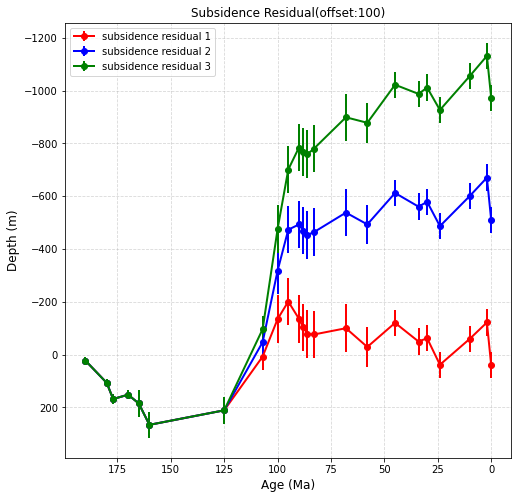

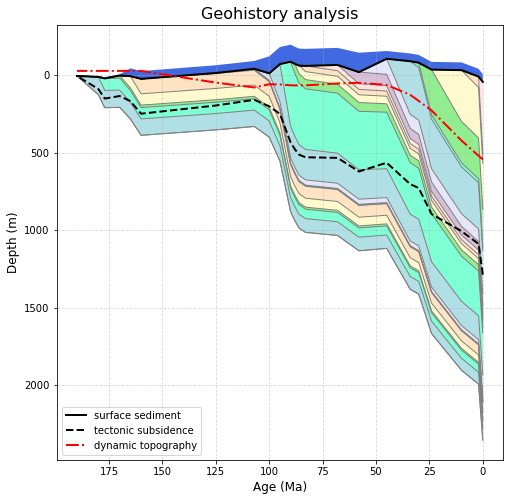

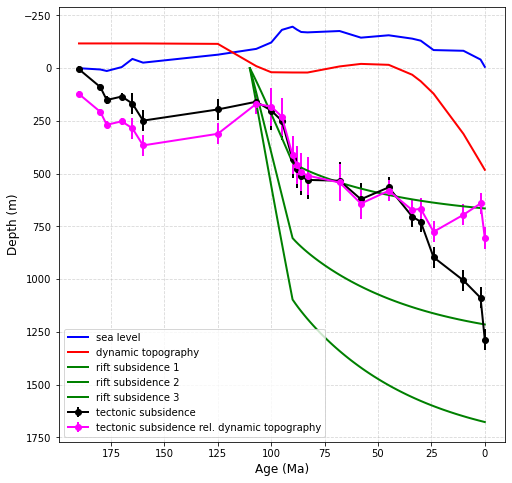

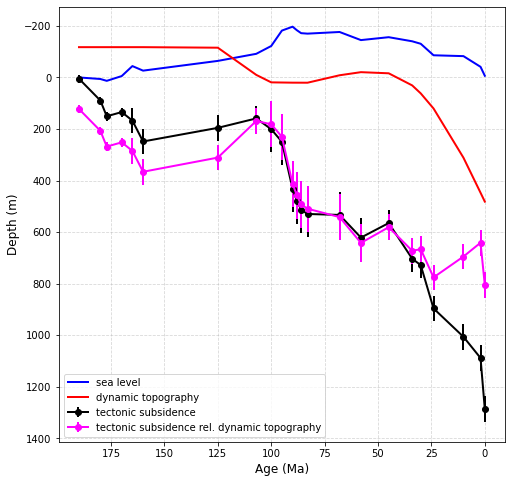

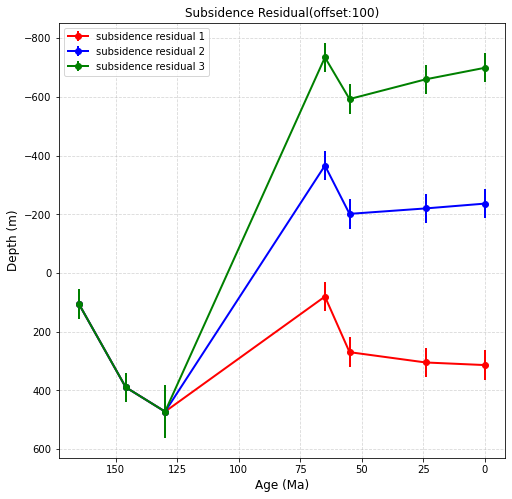

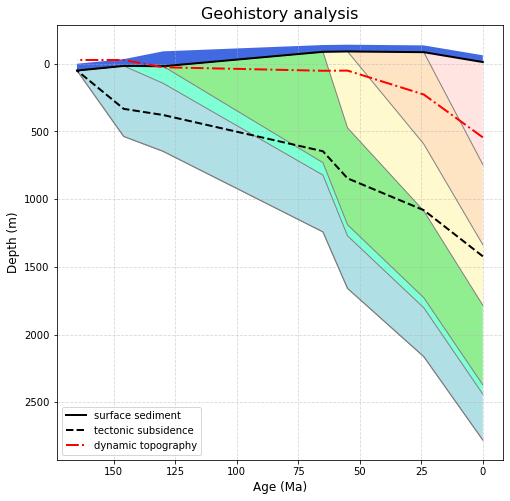

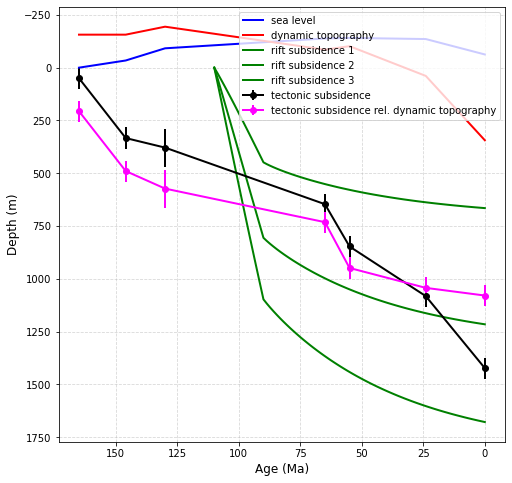

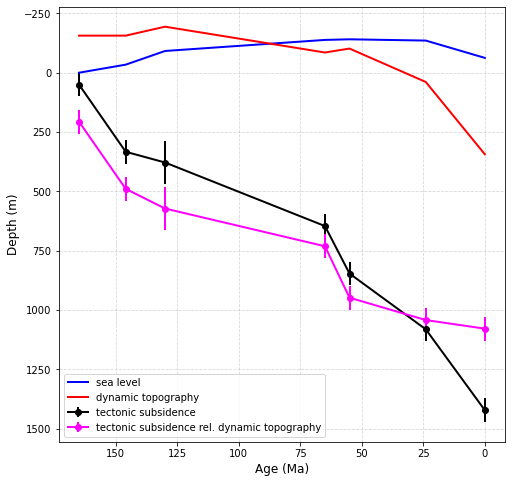

In [24]:
import warnings, os
from pathlib import Path

import pybacktrack
import RiftSubsidence as rs

well_names=['sunrise', 'swift'] #add more wells here

out_dir="my_results"
Path(out_dir).mkdir(parents=True, exist_ok=True)#make output dir

for well_name in well_names:
    backstrip_well_filename = f'wells/{well_name}.txt'
    
    warnings.filterwarnings("ignore", "Well thickness .* is larger than the total sediment thickness")
    warnings.filterwarnings("ignore", ".* does not cover, or cannot interpolate, well location .*")

    well, decompacted_wells = pybacktrack.backstrip_well(
        backstrip_well_filename,
        pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
        sea_level_model='Haq87_SealevelCurve_Longterm')

    dynamic_topography_model_M6 = pybacktrack.DynamicTopography.create_from_bundled_model(
        'M6', well.longitude, well.latitude)

    #load cfg file
    rs.read_cfg_file('parameters.json')
    rs.PLABEL = well_name #change the label in parameters.json to well_name
    
    #run RiftSubsidence with parameters in parameters.json
    rs.run()

    # Read the output from running RiftSubsidence.
    rift_subsidence_output_run = read_rift_subsidence_output(well_name)

    # Plot the backstripped tectonic subsidence, along with the subsidence output by RiftSubsidence for various BETA values.
    fig = plt.figure(figsize=(8,8))
    plot_tectonic_subsidence(
        fig.gca(),
        decompacted_wells,
        plot_sea_level=False,
        dynamic_topography_model=dynamic_topography_model_M6,
        plot_subsidence_minus_dynamic_topography=False,
        rift_subsidence_output=rift_subsidence_output_run,
        offset=100,
        plot_dynamic_topography=False,
        plot_tectonic_subsidence_data=False,
        plot_rift_subsidence_output = False,
        plot_tectonic_minus_dynamic_topography_minus_rift = True)
    
    #save the figure
    fig.savefig(f'{well_name}_residual.png')
    os.system(f'mv {well_name}_residual.png {out_dir}')
    
    # Retrieve and plot the decompacted sediment depths, etc.
    fig = plt.figure(figsize=(8,8))
    plot_decompacted_sediment_depths(
        fig.gca(),
        *get_decompacted_sediment_depths(well, decompacted_wells, dynamic_topography_model_M7))
    
    #save the figure
    fig.savefig(f'{well_name}_sediment_depths.png')
    os.system(f'mv {well_name}_sediment_depths.png {out_dir}')
    
    # Plot the backstripped tectonic subsidence, along with the subsidence output 
    # by RiftSubsidence for various BETA values.
    fig = plt.figure(figsize=(8,8))
    plot_tectonic_subsidence(
        fig.gca(),
        decompacted_wells,
        plot_sea_level=True,
        dynamic_topography_model=dynamic_topography_model_M6,
        plot_subsidence_minus_dynamic_topography=True,
        rift_subsidence_output=rift_subsidence_output_run,
        offset=0)
    
    #save the figure
    fig.savefig(f'{well_name}_tectonic_rift_subsidence.png')
    os.system(f'mv {well_name}_tectonic_rift_subsidence.png {out_dir}')
    
    fig = plt.figure(figsize=(8,8))
    plot_tectonic_subsidence(
        fig.gca(),
        decompacted_wells,
        plot_sea_level=True,
        dynamic_topography_model=dynamic_topography_model_M6,
        plot_subsidence_minus_dynamic_topography=True)
    
    #save the figure
    fig.savefig(f'{well_name}_tectonic_subsidence.png')
    os.system(f'mv {well_name}_tectonic_subsidence.png {out_dir}')
    
    #compute residual stats and save results
    compute_residual_stats(well_name, decompacted_wells,rift_subsidence_output_run, 
                           dynamic_topography_model_M6, offset=100)
    os.system(f'mv {well_name}_residual_stats.txt {out_dir}')
    
    os.system(f'mv {well_name}.dat {out_dir}')

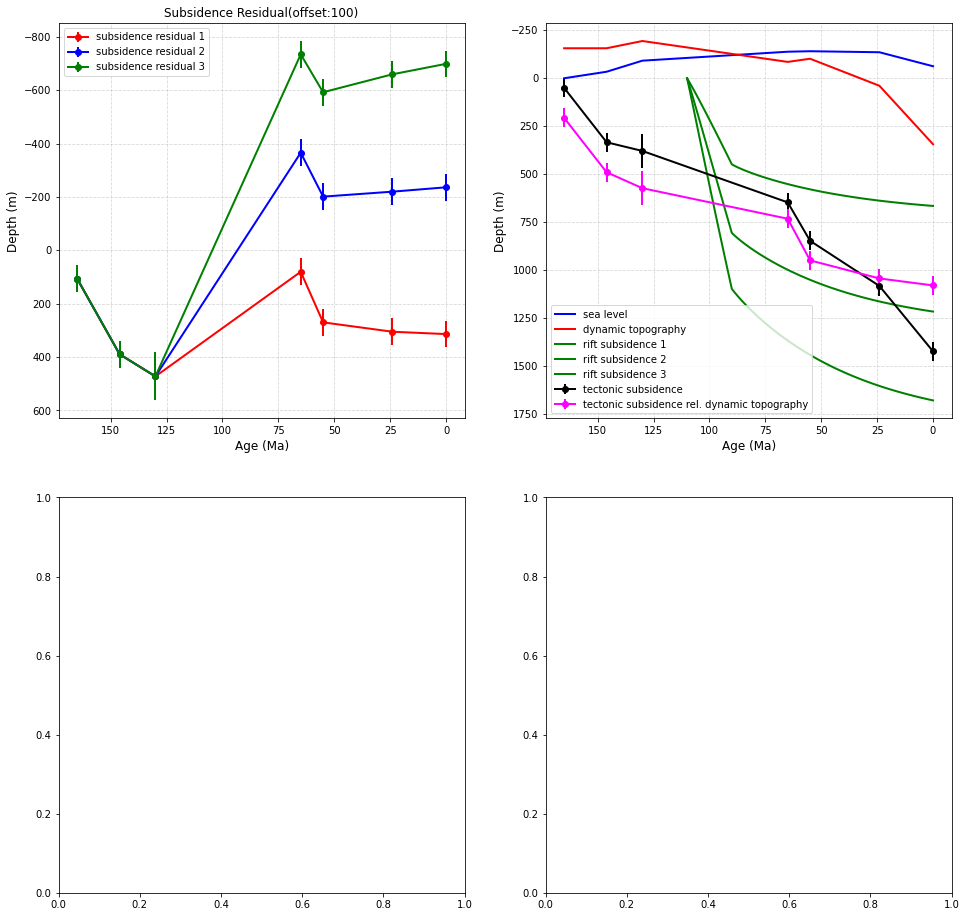

In [25]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2,figsize=(16,16))

plot_tectonic_subsidence(
        ax1,
        decompacted_wells,
        plot_sea_level=False,
        dynamic_topography_model=dynamic_topography_model_M6,
        plot_subsidence_minus_dynamic_topography=False,
        rift_subsidence_output=rift_subsidence_output_run,
        offset=100,
        plot_dynamic_topography=False,
        plot_tectonic_subsidence_data=False,
        plot_rift_subsidence_output = False,
        plot_tectonic_minus_dynamic_topography_minus_rift = True)


plot_tectonic_subsidence(
        ax2,
        decompacted_wells,
        plot_sea_level=True,
        dynamic_topography_model=dynamic_topography_model_M6,
        plot_subsidence_minus_dynamic_topography=True,
        rift_subsidence_output=rift_subsidence_output_run,
        offset=0)

#
#plot the other two here
#

fig.savefig('./Sunrise.pdf')